In [107]:
# We load here the libraries we are going to use
import netCDF4 as nc
import numpy as np
import matplotlib.pyplot as plt
import matplotlib as mpl
import cartopy.crs as ccrs
import cartopy.mpl.ticker as cmt
import cartopy.io.shapereader as shpreader
import numpy as np
import pandas as pd
from netCDF4 import Dataset
import matplotlib.pyplot as plt
import cartopy.crs as ccrs

import xarray as xr
import metpy.calc as mpcalc
from metpy.cbook import get_test_data
from metpy.units import units


In [108]:
#pip install metpy

In [132]:
def DibujoMapaHorizontal(lon,lat,var,levels, mapbar,unidades, titulo, figura):
    fig, ax = plt.subplots(figsize=(22,7), ncols=1)
    ax=plt.subplot(1,1,1,projection=ccrs.PlateCarree())
    im=ax.contourf(lon,lat,var,levels, cmap = mapbar)
    ax.coastlines(linewidth = 2);
    gl=ax.gridlines(draw_labels = True);
    gl.ylabels_right = False
    gl.xlabels_top = False
    fig.colorbar(im,ax=ax,orientation = 'vertical',shrink=0.8, label = unidades)
    im2=ax.contour(lon,lat,var,im.levels, colors='gray')
    fig.suptitle(titulo)
    fig.savefig(figura);
    
def DibujoMapaHorizontal_var_viento(lon,lat,var,var2,var3,levels, mapbar,unidades,atributos_flechas, titulo, figura):
    fig, ax = plt.subplots(figsize=(22, 7), ncols=1)
    ax=plt.subplot(1,1,1,projection=ccrs.PlateCarree())
    im=ax.contourf(lon,lat,var,levels, cmap = mapbar)

    # para el viento
    im2=ax.quiver(lon,lat,var2, var3,color='dimgray')
    qk=ax.quiverkey(im2, atributos_flechas[0], atributos_flechas[1], atributos_flechas[2], label=str(atributos_flechas[2])+' m/s')
    
    ax.coastlines(linewidth = 2);
    gl=ax.gridlines(draw_labels = True);
    gl.ylabels_right = False
    gl.xlabels_top = False
    fig.colorbar(im,ax=ax,orientation = 'vertical',shrink=0.8, label = unidades)
    im2=ax.contour(lon,lat,var,im.levels, colors='black')
    fig.suptitle(titulo)
    fig.savefig(figura);
    
def DibujoMapaHorizontal_2var(lon,lat,var,var2,levels, mapbar,unidades,levels2, titulo, figura):
    fig, ax = plt.subplots(figsize=(22, 7), ncols=1)
    ax=plt.subplot(1,1,1,projection=ccrs.PlateCarree())
    im=ax.contourf(lon,lat,var,levels, cmap = mapbar)
    ax.coastlines(linewidth = 2);
    gl=ax.gridlines(draw_labels = True);
    gl.ylabels_right = False
    gl.xlabels_top = False
    fig.colorbar(im,ax=ax,orientation = 'vertical',shrink=0.8, label = unidades)
    im2=ax.contour(lon,lat,var2,levels2, colors='black')
    fig.suptitle(titulo)
    fig.savefig(figura);

In [163]:
DirDatos=r"C:/Users/Portatil/Desktop/"
data500= xr.open_dataset(DirDatos+'geopt500.nc')
data1000= xr.open_dataset(DirDatos+'geopt1000.nc')

lon,lat,level,time = data500['z'].metpy.coordinates('longitude', 'latitude', 'vertical', 'time')
lon,lat,level,time = data1000['z'].metpy.coordinates('longitude', 'latitude', 'vertical', 'time')

In [164]:
# 21 de enero (curvatura): los datos empiezan el 1 de enero y hay un dato diario.
dias_mes=np.array([31, 28, 31, 30, 31, 30, 31, 31, 30, 31, 30, 31])
mes=1
dia=30
t=np.sum(dias_mes[0:mes-1])+dia-1

# cojo el tiempo que me interesa OJO: es geopotencial, no altura geopotencial!!!
hgt500=data500['z'].metpy.sel(level=500,time=time[t])

# lo divido por g:
hgt500=hgt500/9.81

In [165]:
# hago las mallas de las longitudes y las latitudes
lat2,lon2 = xr.broadcast(lat, lon)
# calculamos la malla de diferenciales de x e y
dx, dy = mpcalc.lat_lon_grid_deltas(lon2*np.pi/180, lat2*np.pi/180)
#calculamos el parametro de coriolis:
f = mpcalc.coriolis_parameter(lat2*np.pi/180)

In [166]:
#calculo el viento geostrófico: lo hago por pasos:
#primero calculo el diferencial de la altura geopotencial
dhdy500 = mpcalc.first_derivative(hgt500, delta=dy, axis=-2)
dhdx500 = mpcalc.first_derivative(hgt500, delta=dx, axis=-1)
norm_factor = 9.81 / f
u_geo500=-norm_factor * dhdy500
v_geo500=norm_factor * dhdx500

C:\Users\Portatil\anaconda3\lib\site-packages\pint\facets\plain\quantity.py:1345: RuntimeWarning: invalid value encountered in divide
  magnitude = magnitude_op(new_self._magnitude, other._magnitude)


In [167]:
#selecciono la región para dibujar:
lonlims=[220, 381]
latlims=[-10, 81]
lat_index = np.logical_and(lat >= latlims[0], lat <= latlims[1])
lon_index = np.logical_and(lon >= lonlims[0], lon <= lonlims[1])
box_index = np.logical_and(lat_index, lon_index)

In [168]:
u_geo500=np.array(u_geo500)
#u_geo500=u_geo500[box_index]               #la variable que quiero selecionar la box_index#
v_geo500=np.array(v_geo500)
#v_geo500=v_geo500[box_index]                          # si me da error tengo que pasar lo de abajo  como un array

# lo mismo para la altura geopotencial (tengo que pasarlo a array para que funcione)
hgt500=np.array(hgt500)        #ug500=np.array(ug500)
#hgt500=hgt500[box_index]
hgt500.shape
#u_geo500.shape
#v_geo500.shape

(161, 320)

In [169]:
# selecciono la region de u y v
ug500=u_geo500[box_index]
vg500=v_geo500[box_index]

# lo mismo para la altura geopotencial (tengo que pasarlo a array para que funcione)
hgt500=np.array(hgt500)
hgt500=hgt500[box_index]

In [170]:
lons=lon[(lon>=lonlims[0])&(lon<=lonlims[1])]
lats=lat[(lat>=latlims[0])&(lat<=latlims[1])]
[nlat]=lats.shape
[nlon]=lons.shape

C:\Users\Portatil\AppData\Local\Temp\ipykernel_6084\4096270509.py:16: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax=plt.subplot(1,1,1,projection=ccrs.PlateCarree())


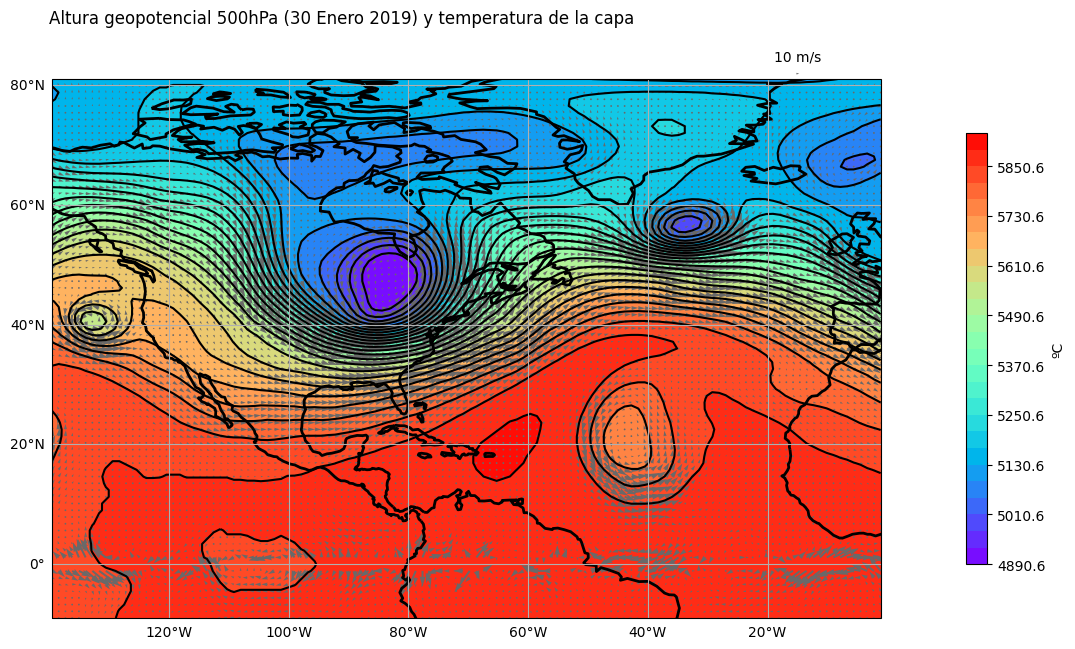

In [172]:
cmin=np.min(hgt500)
cmax=np.max(hgt500)+40
levels=np.arange(cmin,cmax,40)
mapbar='rainbow'
titulo='Altura geopotencial 500hPa (30 Enero 2019) y temperatura de la capa'
unidades='ºC'
figura='Temperature.png'
# flechas se usa para seleccionar dónde irá la flecha "modelo" y qué magnitud mostrará
flechas=[ 0.9, 1.01, 10]
DibujoMapaHorizontal_var_viento(lons,lats,np.reshape(hgt500,(nlat,nlon)),np.reshape(ug500,(nlat,nlon)),np.reshape(vg500,(nlat,nlon)),levels, mapbar,unidades,flechas, titulo, figura)
